# Atmospheric absorption spectra

This notebook uses ARTS to calculate absorption spectra, and these to perform various calculations.   The setu put depends on where ARTS is located in the local directory system.  The absorption spectrum routine is adapted from excercises orginally developed by Manfred Brath, Oliver Lemke for thier course on remote sensing and radiative transfer. 

In [1]:
%matplotlib inline

import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xarray as xr
import os.path
import sys

work_root       = '/Users/m219063/work/'
#aes_thermo_root = work_root+'notes-and-notebooks/python/'
arts_pyarts_root= work_root+'arts/build/python/'
arts_data_root  = work_root+'data/'
arts_cntrl_root = work_root+'arts/controlfiles/general/'

#if aes_thermo_root not in sys.path:
#    sys.path.append(aes_thermo_root)
if arts_pyarts_root not in sys.path:
    sys.path.append(arts_pyarts_root)
    
import pyarts
import aes_thermo.constants as mt
import aes_thermo.functions as aes_functions

# make plot folder, if it is not existing
os.makedirs("plots", exist_ok=True)

cache=None

grav = mt.grav_earth

In [2]:
def calculate_absxsec(
    species="N2O",
    pressure=800e2,
    temperature=300.0,
    fmin=10e9,
    fmax=2000e9,
    fnum=10_000,
    lineshape="LP",
    normalization="RQ",
    verbosity=0,
    vmr=0.05,
    lines_off=0):
    """Calculate absorption cross sections.

    Parameters:
        species (str): Absorption species name.
        pressure (float): Atmospheric pressure [Pa].
        temperature (float): Atmospheric temperature [K].
        fmin (float): Minimum frequency [Hz].
        fmax (float): Maximum frequency [Hz].
        fnum (int): Number of frequency grid points.
        lineshape (str): Line shape model.
                            Available options:
                            DP        -      Doppler profile,
                            LP        -      Lorentz profile,
                            VP        -      Voigt profile,
                            SDVP      -      Speed-dependent Voigt profile,
                            HTP       -      Hartman-Tran profile.
        normalization (str): Line shape normalization factor.
                            Available options:
                            VVH       -      Van Vleck and Huber,
                            VVW       -      Van Vleck and Weisskopf,
                            RQ        -      Rosenkranz quadratic,
                            None      -      No extra normalization.  
        verbosity (int): Set ARTS verbosity (``0`` prevents all output).
        vmr (float): Volume mixing ratio. This is mainly important for the 
                     water vapor continua.
        lines_off (int): Switch off lines, if no contnua is selected,
                         absorption will be zero.

    Returns:
        ndarray, ndarray: Frequency grid [Hz], Abs. cross sections [m^2]
    """
    # Create ARTS workspace and load default settings
    ws = pyarts.workspace.Workspace(verbosity=0)
    ws.execute_controlfile(arts_cntrl_root+"general.arts")
    ws.execute_controlfile(arts_cntrl_root+"continua.arts")
    ws.execute_controlfile(arts_cntrl_root+"agendas.arts")
    ws.verbositySetScreen(ws.verbosity, verbosity)

    # We do not want to calculate the Jacobian Matrix
    ws.jacobianOff()

    # Agenda for scalar gas absorption calculation
    ws.abs_xsec_agenda = ws.abs_xsec_agenda__noCIA

    # Define absorption species
    ws.abs_speciesSet(species=[species])
    ws.ArrayOfIndexSet(ws.abs_species_active, [0])
    ws.abs_lines_per_speciesReadSpeciesSplitCatalog(basename=arts_data_root+'arts-cat-data/lines/')
    ws.abs_lines_per_speciesSetLineShapeType(option=lineshape)
    ws.abs_lines_per_speciesSetCutoff(option="ByLine", value=750e9)
    ws.abs_lines_per_speciesSetNormalization(option=normalization)  
    if lines_off:
        ws.abs_lines_per_speciesSetEmpty()

    # Create a frequency grid
    ws.VectorNLinSpace(ws.f_grid, fnum, fmin, fmax)

    # Throw away lines outside f_grid
    ws.abs_lines_per_speciesCompact()

    # Atmospheric settings
    ws.AtmosphereSet1D()
    ws.stokes_dim = 1

    # Setting the pressure, temperature and vmr
    ws.rtp_pressure    = float(pressure)  # [Pa]
    ws.rtp_temperature = float(temperature)  # [K]
    ws.rtp_vmr         = np.array([vmr])  # [VMR]
    ws.Touch(ws.rtp_nlte)

    # isotop
    ws.isotopologue_ratiosInitFromBuiltin()

    # Calculate absorption cross sections
    ws.abs_xsec_agenda_checked =1
    ws.propmat_clearsky_agenda_checked = 1
    ws.lbl_checkedCalc()
    ws.propmat_clearskyInit()
    ws.propmat_clearskyAddLines()
    ws.propmat_clearskyAddXsecAgenda()

    # Convert abs coeff to cross sections on return
    number_density = pressure*vmr / (kB * temperature)
    
    return (ws.f_grid.value.value.copy(),
            ws.propmat_clearsky.value.data.value[0, 0, :, 0].copy() / number_density)

In [3]:
c,h,kB,N_avo        = mt.fundamental()
Rd,Rv,cpd,cpv,cl,ci = mt.rankine()

Rstar = kB*N_avo
sigma = 2*(np.pi**5) * kB**4 / (15 * h**3 * c**2)

Tsfc       = 288.
Psfc       = 98443      # Pa
mass_atm   = mt.mass_atm

m_dry = mt.md

Planck = np.vectorize(aes_functions.Planck)

H2O,CO2,CH4,N2O,O3 = 'H2O','CO2','CH4','N2O','O3' 
H2O_plus = 'H2O, H2O-SelfContCKDMT252, H2O-ForeignContCKDMT252'
CO2_plus = 'CO2, CO2-CKDMT252'

x_h2o = 0.01 # in actuality this varies, and is not provided within aes_thermo; so we take this as a mean
vfrc  = {'CO2': mt.x_co2 , 'H2O': x_h2o, 'CH4': mt.x_ch4, 'N2O': mt.x_n2o, 'O3': mt.x_o3}
mass  = {'CO2': mt.m_co2 , 'H2O': mt.m_h2o, 'CH4': mt.m_ch4, 'N2O': mt.m_n2o, 'O3': mt.m_o3}
col   = {'CO2': 'brown', 'H2O': 'dodgerblue', 'CH4': 'red', 'N2O': 'green', 'O3': 'grey'}
conc  = {}
burd  = {}
for key in mass:
    conc[key] = vfrc[key]*(Psfc/(kB*Tsfc))
    burd[key] = mass_atm*mass[key]/m_dry * vfrc[key]

def species(S):
    if (S.find(',')) > 0 :
        return S[0:S.find(',')]
    return S

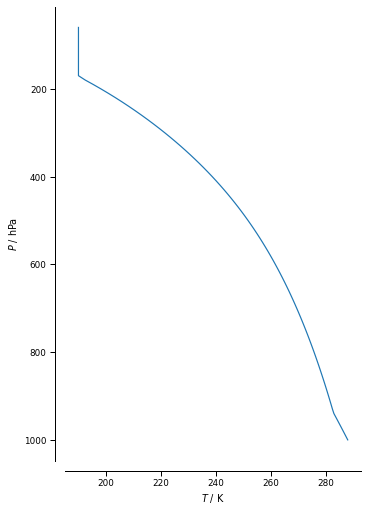

In [4]:
#
# construct a sounding from a moist adiabat
#
Tsnd = np.vectorize(aes_functions.T_from_Tl)
Tl   = 288.
RH   = 0.75
dP   = 1000.
P    = np.arange(1.e5,0.5e4,-dP)
TK   = np.maximum(Tsnd(Tl,P,0.008),190.)
rho  = P/Tl/Rd
dz   = dP / (grav * rho)
iwv  = (aes_functions.pp2sm(RH*aes_functions.es(TK),P)*rho*dz).sum()

zi   = np.zeros(len(dz)+1)
zi[1:]  = np.cumsum(dz)

sns.set_context('paper')
fig, ax = plt.subplots(figsize = (5,7), constrained_layout = True)

ax.plot(TK,P/100.)
plt.gca().invert_yaxis()

ax.set_xlabel("$T$ / K")
ax.set_ylabel("$P$ / hPa")
#plt.grid()
sns.despine(offset=10)
fig.savefig('plots/moistadiabat.pdf')

/Users/m219063/opt/miniforge3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/m219063/opt/miniforge3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


7.797321281063826
28.75077030299703
100.47916729719068
334.2107192248542


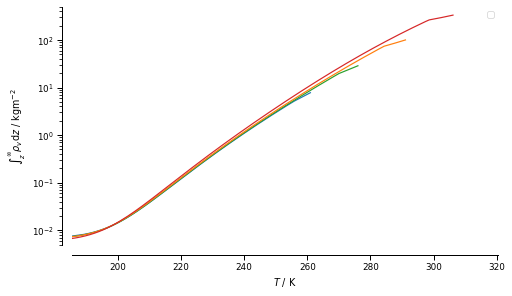

In [5]:
fig, ax = plt.subplots(figsize = (7,4), constrained_layout = True)

colors = ['tab:red','tab:orange','tab:green','tab:blue']
dP   = 1000.
Psrf = 101325.
P    = np.arange(Psrf,dP,-dP/4)[::-1]
Tcp =185.
for Tl in np.arange(260,320,15):
    qsrf   = aes_functions.pp2sm(RH*aes_functions.es(Tl),Psrf)
    color = colors.pop()
    TK   = np.maximum(Tsnd(Tl,P,qsrf),Tcp)
    rho  = P/TK/Rd
    dz   = dP / (grav * rho)
    qt   = aes_functions.pp2sm(RH*aes_functions.es(TK),P)
    co2  = aes_functions.pp2sm(400e-6,P)
    qt[TK<=Tcp] = np.min(qt[TK>Tcp])
    wvp  = qt*dP/grav
    wvp[0] = aes_functions.pp2sm(RH*aes_functions.es(Tcp),P[0])*P[0]/grav
    cwv  = wvp.cumsum()
    ax.semilogy(TK,cwv,c=color)

    cco2  = 400.e-6*P/grav
#    if (Tl==260 or Tl==305):
#        ax.semilogy(TK,cco2,c=color, ls='dotted')
    print (cwv[-1])

ax.set_xlim(Tcp+0.5,320.5)
#ax.axhline(y=1.e-3, color='k', linestyle='dotted')
#ax.set_xlim(0, kmx)
ax.set_ylim(5.e-3, 5.e2)
#ax.set_xticks(np.arange(200,2400,200))
ax.set_xlabel("$T$ / K")
ax.set_ylabel("$\int_z^\infty\\rho_v \mathrm{d}z $ / kgm$^{-2}$")
plt.legend()
#plt.grid()

sns.despine(offset=10)
fig.savefig('plots/columnwatervapor.pdf')

[0.00061023 0.00061023 0.00061023 0.00061023 0.00061023 0.00061023
 0.00061023 0.00061023 0.00061023 0.00061023 0.00061023 0.00061023
 0.00061023 0.00061023 0.00061023 0.00061023 0.00061023 0.00061023
 0.00061023 0.00061023 0.00061023 0.00061023 0.00061023 0.00061023
 0.00061023 0.00061023 0.00061023 0.00061023 0.00061023 0.00061023
 0.00061023 0.00061023 0.00061023 0.00061023 0.00061023 0.00061023
 0.00061023 0.00061023 0.00061023 0.00061023 0.00061023 0.00061023
 0.00061023 0.00061023 0.00061023 0.00061023 0.00061023 0.00061023
 0.00061023 0.00061023 0.00061023 0.00061023 0.00061023 0.00061023
 0.00061023 0.00061023 0.00061023 0.00061023 0.00061023 0.00061023
 0.00061023 0.00061023 0.00061023 0.00061023 0.00061023 0.00061023
 0.00061023 0.00061023 0.00061023 0.00061023 0.00061023 0.00061023
 0.00061023 0.00061023 0.00061023 0.00061023 0.00061023 0.00061023
 0.00061023 0.00061023 0.00061023 0.00061023 0.00061023 0.00061023
 0.00061023 0.00061023 0.00061023 0.00061023 0.00061023 0.0006

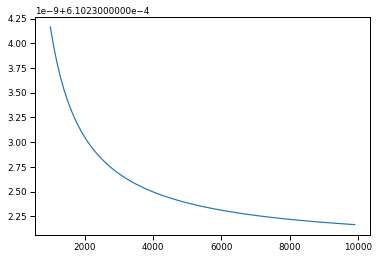

In [6]:
P=np.arange(1000,10000,100)
X = aes_functions.pp2sm(RH*aes_functions.es(180),P)*P/grav
plt.plot(P,X)
print (X)

## 1. Mass absorption spectra (in the microwave through the thermal infrared).

In this example we plot (on a log scale) the absorption spectra (in units of m^2/kg).  Note that at earth temperatures 85% of the emissions are in the wavenumber range between 300 and 1500 cm$^{-1}.$  We consider the absorption spectrum for two gases, H$_2$O and CO$_2.$  The script can be easily adapted to consider other gases, e.g., O$_3$, CH$_4$, but for some (e.g., HCl) the appropriate constants would need to be defined.

Frist, the absorption is calculated for a specific temperature (300 K) and pressure (1013.25 hPa) which influences mostly the line broadening.  

To compute the total optical depth from a gas at the specific wavelength the absorption spectrum must be integrated over the concentration.  However a rough estimate can be obtained by using the line properties at one temperature and pressure, and simply multiplying this by the burden.  Given the absorption this allows us to estimate a the critical optical depth $\tau=1$ is indicated, showing the region of the atmospheric window.

For these calcualtions, for CO$_2$ the present day burden is about 6 kg; for H$_2$O this is variable, as it depends on temperature, but 30 kg/m^2 is a typical summer number, and these values are used.

## Absorption Spectra

Calculate absorption spectra and optical depths for different gasses and different atmpsheric conditions:
* Absorption spectrum of H2O and CO2
* Atmospheric opacity $\mathcal{O} = 1-\exp^{-\tau}$ for different gases

In plotting these quantitie we sometimes smooth the spectra, with a gaussian smooothing with a sigma given in terms of the number of wavenumbers, i.e., as a function of the frequency discretization given by fnum.  To calculate the optical depth of variable gases like H2O we need to integrate their specific masses over the depth of the atmosphere, given some distribution.  For water vapor we assume it has a constant relative humidity, here specified as 0.7

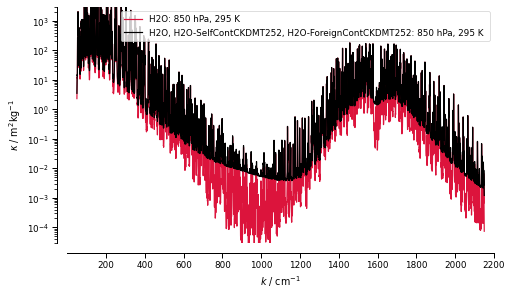

In [7]:
kmn,kmx = 50,2150
fnum    = int(20*(kmx-kmn))
P, T    = 85000,295
kwargs = {
    "fmin":        kmn*c*100,  # 10 cm-1
    "fmax":        kmx*c*100,  # 3250 cm-1
    "fnum":        fnum,
    'pressure':    P,
    'temperature': T,
    'vmr':         x_h2o,
    }

sns.set_context('paper')
fig, ax = plt.subplots(figsize = (7,4), constrained_layout = True)
#
# sometimes it is useful to smooth the spectra.  Here I smooth it with a guassian filter with sigma (wsig) given by some multiple
# of the frequency discretization, i.e, wsig.    The frequency discretizaiton is given by fnum, here defined as 1/20th of a Hz.  The
# weighting window is defined over a three sigma window.  To remove the weighting completely, simply plot fld_w rather than fld_w
#
wsig  = 6
w     = np.exp(-0.5*(np.arange(-3*wsig,3*wsig)/wsig)**2) 
ls    = 'solid'
coldflag=True
for S in [H2O,H2O_plus]:
    Sx = species(S)
    kwargs['vmr'] = vfrc[Sx]
    freq, abs_xsec = calculate_absxsec(S, **kwargs)
    fld_w = (np.convolve(abs_xsec, w, 'same')/ np.sum(w)) * (1000 * N_avo / mass[Sx])
    kay   = freq/c/100
    if (S.find(',')<0):
        ax.semilogy(kay, fld_w ,label=f"{S}: {P/100:.0f} hPa, {T:.0f} K ",c='crimson')
    else:
        ax.semilogy(kay, fld_w ,label=f"{S}: {P/100:.0f} hPa, {T:.0f} K ",c='k')


#ax.axhline(y=1/7., color='tab:blue', linestyle='dotted')
#ax.axhline(y=1/25., color='tab:green', linestyle='dotted')
#ax.axhline(y=1/80., color='tab:orange', linestyle='dotted')


#ax.semilogy(kay,700*np.exp(-np.abs(kay-667)/12),c='gray',ls='dotted')

ax.set_xlim(0, kmx)
ax.set_ylim(3.e-5, 3.e3)
ax.set_xticks(np.arange(200,2400,200))
ax.set_xlabel("$k$ / $\sf cm^{-1}$")
ax.set_ylabel("$\kappa$ / $\sf m^2 kg^{-1}$")
plt.legend()
#plt.grid()
sns.despine(offset=10)

fig.savefig('plots/co2-h2o-abs.pdf')

## Vertically ingegrated optical depth 

In this example we calculate the optical depth layer wise so as to account for the vertical distribution of water vapor and compare this to what would be estimated by some effective absorption multiplied by the total burden.  We find that for the given circumstance using the line-spectrum corresponding to the sounding at 800 hPa is a pretty good approximation to the vertical integral when measured by the response of the Planck function to warming and the mean optical depth.

lambda =  2.03 W/m2, IWV = 23.59 kg/m2, tau-bar = 1937.35
lambda =  2.00 W/m2, IWV = 23.59 kg/m2, tau-bar = 1936.53


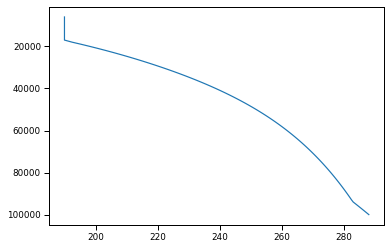

In [9]:
Tsnd = np.vectorize(aes_functions.T_from_Tl)
RH   = 0.85
Tl   = 288.
dP   = 1000.
P    = np.arange(1.e5,0.5e4,-dP)
TK   = np.maximum(Tsnd(Tl,P,0.008),190.)
rho  = P/TK/Rd
dz   = dP / (grav * rho)

zi      = np.zeros(len(dz)+1)
zi[1:]  = np.cumsum(dz)

plt.plot(TK,P)
plt.gca().invert_yaxis()
#TK=288.

tau = 0.
wvp = aes_functions.pp2sm(RH*aes_functions.es(TK),P)*rho*dz
xm  = (mass['H2O']/1000) / N_avo
iwv = wvp.sum()
dT  = 0.1

for i,Px in enumerate(P):
    Tx = TK[i]
    kwargs = {
        "fmin":        kmn*c*100,  # 10 cm-1
        "fmax":        kmx*c*100,  # 3250 cm-1
        "fnum":        fnum,
        'pressure':    Px,
        'temperature': Tx,
        'vmr':         RH*aes_functions.es(Tx)/Px,
    }
    freq, abs_xsec = calculate_absxsec("H2O, H2O-SelfContCKDMT252, H2O-ForeignContCKDMT252", **kwargs)
    tau   += wvp[i] * abs_xsec / xm
    if int(Px) == 80000: 
        taux = iwv * abs_xsec / xm
        dB   = ((Planck(TK[0]+dT,freq)- Planck(TK[0],freq))*np.exp(-taux)*(freq[1]-freq[0])).sum()

print (f'lambda = {dB*np.pi/dT:5.2f} W/m2, IWV = {wvp.sum():.2f} kg/m2, tau-bar = {taux.mean():.2f}')

dB = ((Planck(TK[0]+dT,freq)- Planck(TK[0],freq))*np.exp(-tau)*(freq[1]-freq[0])).sum()
print (f'lambda = {dB*np.pi/dT:5.2f} W/m2, IWV = {wvp.sum():.2f} kg/m2, tau-bar = {tau.mean():.2f}')
#lambda =  1.54 W/m2, IWV = 24.52 kg/m2, tau-bar = 2035.32
#lambda =  1.88 W/m2, IWV = 24.52 kg/m2, tau-bar = 2014.55

In [10]:
for Px in P:
    if int(Px) == 80000: print (Px)

80000.0


# Work in progress

This contains ported code from the greenhouse class, needs to be cleaned, but it is a start.

In [11]:
kmn,kmx   = 730,740
fnum      = int(10*(kmx-kmn))
dnu  = 10*c
nus  = np.arange(kmn*100*c,kmx*100*c,dnu)
T=300.
print(np.pi*np.sum(Planck(T,nus)*dnu), x_co2*Psfc*m_co2/m_dry/g)
slope = np.log(700/0.01)/133
dx = np.log(2)
print (np.exp(0),np.exp(-12.5))

T=300
kmn,kmx   = 2000,5000
fnum      = int(10*(kmx-kmn))
dnu  = 10*c
nus  = np.arange(kmn*100*c,kmx*100*c,dnu)
print(np.pi*np.sum(Planck(T,nus)*dnu)/ (sigma*T**4))

NameError: name 'x_co2' is not defined

In [ ]:

def z2p(z, Tsfc, Psfc,Gamma):
    return Psfc * (1.-Gamma*z/Tsfc)** (g/Rd/Gamma)

def get_sounding(Psfc,Tsfc,delta=-5000,dP_lcl = 8000.,Gamma=6.5e-3):

    Plcl    = Psfc - dP_lcl
    Tlcl    = Tsfc - (Psfc-Plcl) / 1.2 / mt.cpd
    qlcl    = aes_functions.pp2sm(aes_functions.es(Tlcl),Plcl) 
    theta_e = aes_functions.get_theta_e(Tlcl,Plcl,qlcl)
    Tsfc    = Te2T(theta_e,Psfc,qlcl)

    if (delta < 0):
        Psnd    = np.arange(Psfc+delta/2.,-delta/2,delta) 
        Tsnd    = Te2T(theta_e,Psnd,qlcl)
    else:
        Gamma   = 6.5e-3
        Zsnd    = np.arange(delta/2.,20000,delta)
        Tsnd    = Tsfc - Gamma*Zsnd
        Psnd    = z2p(Zsnd, Tsfc, Psfc, Gamma)

    k=0
    while (Tsnd[k]>200):
        k=k+1
    Tsnd[k:] = 200.
        
    return Psnd, Tsnd



In [ ]:
kmn,kmx = 50,2150
fnum    = int(100*(kmx-kmn))
PP      = 85000
xm      = (mass['H2O']/1000) / N_avo
Tsnd    = np.vectorize(aes_functions.T_from_Tl)
RH      = 0.85
dP      = 1000.
P       = np.arange(1.e5,0.5e4,-dP)

Tls = np.arange(250.,305.,2.)
xx  = np.zeros(len(Tls))
for i,Tl in enumerate(Tls):

    TK      = np.maximum(Tsnd(Tl,P,0.008),190.)
    rho     = P/TK/Rd
    dz      = dP / (grav * rho)

    kwargs = {
        "fmin":        kmn*c*100,  # 10 cm-1
        "fmax":        kmx*c*100,  # 3250 cm-1
        "fnum":        fnum,
        'pressure':    PP,
        'temperature': TK.max(),
        'vmr':         aes_functions.es(TK.max())/PP,
    }
    freq, abs_xsec = calculate_absxsec(H2O_plus, **kwargs)
    kay   = freq/c/100

    wvp = aes_functions.pp2sm(RH*aes_functions.es(TK),P)*rho*dz
    iwv = wvp.sum()
    tau = iwv * abs_xsec / xm
    db  = ((Planck(TK.max()+dT,freq)- Planck(TK.max(),freq))*(freq[1]-freq[0]))/dT
    xx[i] = np.pi*(np.exp(-tau)*db).sum()/(4.*5.67e-8*TK.max()**3)
    
print (xx)
#freq = np.arange(80000*c,120000*c,c)
#dT = 0.1
#dB = ((Planck(288.+dT,freq)- Planck(288.,freq))*(freq[1]-freq[0])).sum()
#print (dB*np.pi/dT,wvp.sum())


In [ ]:
fig, ax = plt.subplots(figsize = (7,4), constrained_layout = True)
db = ((Planck(250.+dT,freq)- Planck(250.,freq))*(freq[1]-freq[0]))/dT
ax.plot(kay, np.exp(-tau_c)*db)
print (np.pi*(np.exp(-tau_c)*db).sum()/(4.*5.67e-8*250**3))
db = ((Planck(290.+dT,freq)- Planck(290.,freq))*(freq[1]-freq[0]))/dT
#ax.plot(kay, np.exp(-tau_w)*db)
print (np.pi*(np.exp(-tau_w)*db).sum()/(4.*5.67e-8*290**3))
ax.set_xlim(0, kmx)
sns.despine(offset=10)


In [ ]:
fig, ax = plt.subplots(figsize = (7,4), constrained_layout = True)
ax.semilogy(kay, fld_w)
ax.set_xlim(0, kmx)


In [ ]:
kwargs = {
    "fmin": 300e9,  # 10 cm-1
    "fmax": 100e12,  # 3250 cm-1
    "fnum": 1000,
}

f, h2o_lines = calculate_absxsec(species="H2O", **kwargs)
nu = f / 3e8 / 100  # Hz -> cm-1

fig, ax = plt.subplots()
for continuum in ("Foreign", "Self"):
    f, h2o_with_cont = calculate_absxsec(
        species=f"H2O, H2O-{continuum}ContCKDMT252",
        **kwargs,
    )
    ax.semilogy(nu, h2o_with_cont - h2o_lines, label=continuum)
ax.set_xlim(nu.min(), nu.max())
ax.set_xlabel(r"$\nu$ / $\rm cm^{-1}$")
ax.legend()

In [ ]:
kmn,kmx = 50,2150
fnum = int(20*(kmx-kmn))

sns.set_context('talk')
fig, ax = plt.subplots(figsize = (7,4), constrained_layout = True)
#
# sometimes it is useful to smooth the spectra.  Here I smooth it with a guassian filter with sigma (wsig) given by some multiple
# of the frequency discretization, i.e, wsig.    The frequency discretizaiton is given by fnum, here defined as 1/20th of a Hz.  The
# weighting window is defined over a three sigma window.  To remove the weighting completely, simply plot fld_w rather than fld_w
#
wsig  = 60
w     = np.exp(-0.5*(np.arange(-3*wsig,3*wsig)/wsig)**2) 

P, T  = 100000,300
for S in [H2O]:
    V = es(T)/P
    xm    = (mass[S]/1000) / N_avo
    freq, abs_xsec = calculate_absxsec(S, P, T, fmin=kmn*c*100, fmax=kmx*c*100, fnum=fnum, lines_off=0, vmr=V)
    fld   = abs_xsec / xm
    fld_w = np.convolve(abs_xsec, w, 'same') / np.sum(w) / xm
    kay   = freq/c/100
    plnk=Planck_s(T,freq)*(freq[1]-freq[0])
    ax.semilogy(kay, fld_w ,label=f"{S}: {P/100:.0f} hPa, {T:.0f} K ",c=col[S],zorder=2)

S = H2O_plus
V = 1. * es(T)/P
xm    = (mass[H2O]/1000) / N_avo
freq, abs_xsec = calculate_absxsec(S, P, T, fmin=kmn*c*100, fmax=kmx*c*100, fnum=fnum, lines_off=0, vmr=V)
fld_w = np.convolve(abs_xsec, w, 'same') / np.sum(w) / xm
kay   = freq/c/100
plnk=Planck_s(T,freq)*(freq[1]-freq[0])
ax.semilogy(kay, fld_w ,label=f"{S}: {P/100:.0f} hPa, {T:.0f} K ",c='darkblue',zorder=1)

#ax.axhline(y=1e-1, color='k', linestyle='dotted')
#ax.semilogy(kay,700*np.exp(-np.abs(kay-667)/12),c='gray',ls='dotted')

ax.set_xlim(0, kmx)
ax.set_ylim(3.e-5, 3.e3)
ax.set_xticks(np.arange(200,2400,400))
ax.set_xlabel("$k$ / $\sf cm^{-1}$")
ax.set_ylabel("$\kappa$ / $\sf m^2 kg^{-1}$")
plt.legend(fontsize=8)
plt.grid()
sns.despine(offset=10)

fig.savefig('plots/co2-h2o-abs.pdf')

## Continuum

Here we explore how continuum radiation closes the windwo.  Because it varies with temperature non-linearly, and varies with the number of absorbers to the sqare, we explore the  continuum by integrateing the optical depth over the whole atmosphere.  For this we constuct an idealized sounding consisting of temperature varying with a moist adiabatic lapse rate and set consstant at and above the tropopause, and with relative humidity fixed as a function of temperature.
1. calculate column tau (for each wave number) and H2O burden for different temperature soundings
2. plot the optical depths in the window region 
3. caculate the temperature at which optical depth is one for two different soundings and compare.


In [ ]:
kmn,kmx = 650,1350
fnum    = int(20*(kmx-kmn))

S = H2O_plus
RH   = 0.7
taus_20 = {}

for Tsfc in [290,300,310]:
    
    print ('Computing ',Tsfc)
    Psnd,Tsnd = get_sounding(101300.,Tsfc,delta=-5000.)
    tau       = np.zeros(fnum)
    b         = 0.
    dP        = Psnd[0]-Psnd[1]
    for j,Tx in enumerate(Tsnd):
        Px    = Psnd[j]
        Vx    = RH*aes_functions.es(Tx)/Px
        db    = Vx * (np.min([dP,2*Px])/g) * m_h2o/m_dry
        freq, abs_xsec = calculate_absxsec(S, Px, Tx, fmin=kmn*c*100, fmax=kmx*c*100, fnum=fnum, lines_off=1, vmr=Vx)

        tau   += db * abs_xsec  * (1000 * N_avo / m_h2o)
        b     += db
    
    taus_20[str(Tsfc)]={'tau':tau,'burden':b}

In [ ]:
sns.set_context('talk')
fig, ax = plt.subplots(figsize = (7,4), constrained_layout = True)

wsig  = 120
w     = np.exp(-0.5*(np.arange(-3*wsig,3*wsig)/wsig)**2)

kay = np.linspace(kmn,kmx,fnum)
styles = ['dotted','dashed','solid']
for key in taus_20.keys():
    ls = styles.pop()
    ax.semilogy(kay,taus_20[key]['tau'],label=key+" K",c='k',ls=ls)

ax.axhline(y=1, color='grey', lw=0.5)
#ax.semilogy(kay,700*np.exp(-np.abs(kay-667)/12),c='gray',ls='dotted')

ax.set_xlim(650, 1350)#kmx)
ax.set_ylim(5.e-2, 1.e1)
#ax.set_xticks(np.arange(200,2400,200))
ax.set_xlabel("$k$ / $\sf cm^{-1}$")
ax.set_ylabel("$\\tau$ ")
plt.legend()
#plt.grid()
sns.despine(offset=10)

fig.savefig('plots/h2o-continuum-abs.pdf')

In [ ]:
def optical_depths(S):
    kmn,kmx = 50,2150
    fnum    = int(20*(kmx-kmn))
    kays    = np.linspace(kmn,kmx,fnum)
    dP      = 1000.
    
    nlev    = int(101300/dP)
    RH      = np.arange(0.5,1.,0.2)
    Ts      = np.arange(270,330,10)
    tau     = np.zeros([len(RH),len(Ts),nlev,fnum])
    Tsnd    = np.zeros([len(Ts),nlev])

    for j,Tsfc in enumerate(Ts):
        Psnd,Tsnd[j,:] = get_sounding(101300.,Tsfc,delta=-dP)
        for i,RHx in enumerate(RH):
            print (f'Computing {RHx:.2f} RH, {Tsfc:.0f} K over {len(Psnd):.0f} levels')
            for k,Tx in enumerate(Tsnd[j,:]):
                Px    = Psnd[j]
                Vx    = RHx*aes_functions.es(Tx)/Px
                freq, abs_xsec = calculate_absxsec(S, Px, Tx, fmin=kmn*c*100, fmax=kmx*c*100, fnum=fnum, lines_off=1, vmr=Vx)
                tau[i,j,k,:]   = Vx * (np.min([dP,2*Px])/g)  * abs_xsec  * (1000 * N_avo /m_dry)
    ds   = xr.Dataset(
        {
        'RH': xr.DataArray(
                    data   = RH.astype(np.float32), dims   = ['RH'], coords = [('RH', RH.astype(np.float32))],
                    attrs  = {'longname': 'relative humidity','units' : '-'}
                    ),
        'Tsfc': xr.DataArray(
                    data   = Ts.astype(np.float32), dims   = ['Tsfc'],coords = [('Tsfc', Ts.astype(np.float32))],
                    attrs  = {'longname': 'surface_temperature','units' : 'Kelvin' }
                    ),
        'P': xr.DataArray(
                    data   = Psnd.astype(np.float32),dims   = ['P'],coords = [('P', Psnd.astype(np.float32))],
                    attrs  = {'longname': 'pressure','units' : 'Pa' }
                    ),
        'kay': xr.DataArray(
                    data   = kays.astype(np.float32),dims   = ['kay'], coords = [('kay', kays.astype(np.float32))],
                    attrs  = {'longname': 'wavenumber','units' : 'cm-1'}
                    ),
        'T': xr.DataArray(
                    data   = Tsnd.astype(np.float32),  dims   = ['Tsfc','P'],
                    attrs  = {'longname': 'temperature','units' : 'Kelvin'}
                    ),
        'tau': xr.DataArray(
                    data   = tau.astype(np.float32),dims   = ['RH','Tsfc','P','kay'],
                    attrs  = {'longname': 'optical depth in given layer','units' : '-'}
                    ),
        },
        attrs = {'history': 'created by B Stevens 12 Dec 2021','species': S}
    )
    ds.to_netcdf(path=file_path)
    
    return

In [ ]:
Slist   = ["H2O","H2O, H2O-SelfContCKDMT252, H2O-ForeignContCKDMT252","CO2","O3","CH4"]
Slist   = ["O3","CH4"]

for S in Slist:
    if (len(S)>4):
        file_path ='tau_H2Oplus.nc'
    else:
        file_path ='tau_%s.nc'%S
        
    print ('Preparing %s'%file_path)
    #if (os.path.isfile(file_path)):
    #    print ('file exists; not computing')
    #else:
    optical_depths(S)

In [ ]:
file_path ='tau_H2O.nc'
!ls -lrt
xx = xr.open_dataset(file_path)
print (xx)

In [ ]:
kmn,kmx = 50,2150
fnum    = int(20*(kmx-kmn))

S    = "CO2"
dtau_co2 = {}
dP   = 1000.

for S in S
for Tsfc in [270,280,290,300,310,320]:

    Psnd,Tsnd = get_sounding(101300.,Tsfc,delta=-dP)
    dtau_x = np.zeros([len(Psnd),fnum])
    print (f'Computing {Tsfc:.0f} K at {len(Psnd):3f} levels')
    for j,Tx in enumerate(Tsnd):
        Px    = Psnd[j]
        db    = vfrc[S] * (np.min([dP,2*Px])/g) * mass[S]/m_dry
        freq, abs_xsec = calculate_absxsec(S, Px, Tx, fmin=kmn*c*100, fmax=kmx*c*100, fnum=fnum)
        dtau_x[j,:] = db * abs_xsec  * (1000 * N_avo / mass[S])
    
    dtau_co2[str(Tsfc)]={'tau':dtau_x,'Tsnd':Tsnd,'Psnd':Psnd}

In [ ]:
dtau = xr.open_dataset('tau.nc')
Tsfc=270.
Ts    = np.flipud(dtau.T.sel(Tsfc=Tsfc))
print (dtau)

In [ ]:
Te={}
kay   = dtau.kay
for Tsfc in [270,280,290,300,310,320]:
    xx = np.ones(len(kay))

    Ts    = np.flipud(dtau.T.sel(Tsfc=Tsfc))
    Tp    = np.roll(Ts,-1)
    Tp[-1]=Tsfc
    tau   = np.flipud(dtau.tau.sel(Tsfc=Tsfc))
    tau_c = tau.cumsum(axis=0)
#    print (np.shape(tau_c),np.shape(tau))
    for j,Tx in enumerate(Ts):
        delta  = (1-tau_c[j,:]) *(Tp[j]-Ts[j]) / tau[j,:]
        xx[tau_c[j,:]<1] = Tx + delta[tau_c[j,:]<1]
    xx[xx>Tsfc] = Tsfc
    Te[str(Tsfc)] = xx

sns.set_context('paper')
fig, ax = plt.subplots(figsize = (7,4), constrained_layout = True)

wsig  = 120
w     = np.exp(-0.5*(np.arange(-3*wsig,3*wsig)/wsig)**2) 

styles = ['solid','solid','dashed','dashed','dotted']
colors = ['black','dimgrey','grey','darkgrey','lightgrey']
for Tsfc in [280,290,300,310,320]:
    ax.plot(kay, np.convolve((Te[str(Tsfc)] - Te[str(Tsfc-10)])/10., w, 'same') / np.sum(w)
            , c=colors.pop(), ls=styles.pop(), label=f'{Tsfc-5:.0f} K')
    
ax.set_xlabel("$k$ / $\sf cm^{-1}$")
ax.set_ylabel("$\\Delta T_\mathrm{e} / \\Delta T_\mathrm{sfc}$")
ax.set_ylim(-0.5,1.1)

sns.despine(offset=10)
plt.legend()

fig.savefig('plots/simpson.pdf')

In [ ]:
dtau = xr.open_dataset('tau.nc')
dtau2 = xr.open_dataset('tau_co2.nc')
Tsfc=270.
Ts    = np.flipud(dtau.T.sel(Tsfc=Tsfc))

nus = kay*100*c
dnu = (nus[1]-nus[0]).squeeze()

for Tsfc in [270,280,290,300,310,320]:
    tau_c = dtau.tau.sel(Tsfc=Tsfc).sum(axis=0) - dtau.tau_nl.sel(Tsfc=Tsfc).sum(axis=0)
    tau_co2 = dtau2.tau.sel(Tsfc=Tsfc).sum(axis=0)
    tau_x = tau_c.where(tau_co2<1,0) + tau_co2.where(tau_co2>10,0)
    print('ECS %.2f'%(Tsfc/(np.sum(Planck(Tsfc,nus)*np.exp(-tau_x)))/dnu/np.pi,))

In [ ]:
plt.plot(kay,dtau2.tau.sel(Tsfc=290).sum(axis=0))

In [ ]:
x = - 160 / np.log(0.0025-0.00025)
print (x)
x = - 200 / np.log(0.0011-0.00025)
print (x)
x = np.arange(150,400)
y = 0.00025 + 0.07*np.exp(-x**0.667/8)
plt.plot(x,y)

In [ ]:
S, P, T  = H2O,80000, 290
for P in [30000,50000,70000,90000]:
    freq, abs_xsec = calculate_absxsec("H2O, H2O-ForeignContCKDMT252", P, T, fmin=kmn*c*100, fmax=kmx*c*100, fnum=fnum, lines_off=1)
    print (np.max(abs_xsec)/xm)

In [ ]:
kmn,kmx = 700,750
fnum = int(20*(kmx-kmn))

sns.set_context('paper')
fig, ax = plt.subplots(figsize = (7,4), constrained_layout = True)
#
# sometimes it is useful to smooth the spectra.  Here I smooth it with a guassian filter with sigma (wsig) given by some multiple
# of the frequency discretization, i.e, wsig.    The frequency discretizaiton is given by fnum, here defined as 1/20th of a Hz.  The
# weighting window is defined over a three sigma window.  To remove the weighting completely, simply plot fld_w rather than fld_w
#
wsig  = 10
w     = np.exp(-0.5*(np.arange(-3*wsig,3*wsig)/wsig)**2) 

S, P, T  = CO2,50000,270
xm    = (mass[S]/1000) / N_avo
freq, abs_xsec = calculate_absxsec(S, P, T, fmin=kmn*c*100, fmax=kmx*c*100, fnum=fnum)
fld   = abs_xsec / xm
fld_w = np.convolve(abs_xsec, w, 'same') / np.sum(w) / xm
kay   = freq/c/100
plnk=Planck_s(T,freq)*(freq[1]-freq[0])
ax.plot(kay, fld_w*3.5 ,label=f"{S}: {P/100:.0f} hPa, {T:.0f} K ",c=col[S])
ax.plot(kay, fld_w*7 ,label=f"$2\\times${S}: {P/100:.0f} hPa, {T:.0f} K ",c='orange')
    
#ax.axhline(y=1e-1, color='k', linestyle='dotted')

ax.set_xlim(kmn, kmx)
ax.set_ylim(1, 100)
ax.set_xticks(np.arange(665,765,10))
ax.set_xlabel("$k$ / $\sf cm^{-1}$")
ax.set_ylabel("$\\tau$")
plt.legend()
plt.grid()
sns.despine(offset=10)

fig.savefig('plots/co2-h2o-abs-zoom.pdf')

In [ ]:
kmn,kmx = 400,1600
fnum = int(40*(kmx-kmn))

sns.set_context('paper')
fig, axs = plt.subplots(3,1, figsize = (7,10), constrained_layout = True)

wsig  = 80
w     = np.exp(-0.5*(np.arange(-3*wsig,3*wsig)/wsig)**2) 

Gamma = 6.5e-3
for T,P,j in [(300,101325,0), (300 - Gamma*6e3,z2p(6e3,300,101325.,Gamma),1), (300 - Gamma*12e3,z2p(12e3,300,101325.,Gamma),2)]:
    burd[H2O] = 0.7*IWV(Tsfc=T,Gamma=Gamma,Psfc=P,)
    for S in [CO2,CH4,N2O,O3,H2O]:
        xm    = (mass[S]/1000) / N_avo
        freq, abs_xsec = calculate_absxsec(S, P, T, fmin=kmn*c*100, fmax=kmx*c*100, fnum=fnum)
        fld   = abs_xsec / xm
        fld_w = np.convolve(abs_xsec, w, 'same') / np.sum(w) / xm
        kay   = freq/c/100
        plnk=Planck_s(T,freq)*(freq[1]-freq[0])
        axs[j].plot(kay, 1 - np.exp(-fld_w* burd[S]) ,label=f"{S}",c=col[S])
        axs[j].set_title(f"{P/100:.0f} hPa, {T:.0f} K ",pad=-0.4)
    
        axs[j].set_xlim(kmn, kmx)
        axs[j].set_yticks(np.arange(0,2,1))
        axs[j].set_ylabel("$1 - e^{-\\tau}$")
        axs[j].set_ylim(0, 1.04)
        axs[j].set_xticks(np.arange(400,2000,400))
axs[2].set_xlabel("$k$ / $\sf cm^{-1}$")
plt.legend(ncol=3,fontsize=10)
sns.despine(offset=10)

fig.savefig('plots/opacity.pdf')

In [ ]:
kmn,kmx   = 10,4000
fnum      = int(10*(kmx-kmn))
Ts        = np.arange(270,332,2)
ECS1= []
ECS2= []
for T in Ts:
    burd[H2O] = 0.7*IWV(Tsfc=T,Gamma=Gamma,Psfc=Psfc)
    freq, abs1 = calculate_absxsec(S, Px, Tx, fmin=kmn*c*100, fmax=kmx*c*100, fnum=fnum, lines_off=1, vmr=Vx)
    freq, abs1 = calculate_absxsec('H2O', Psfc, T, fmin=kmn*c*100, fmax=kmx*c*100, fnum=fnum)
    freq, abs2 = calculate_absxsec('CO2', Psfc, T, fmin=kmn*c*100, fmax=kmx*c*100, fnum=fnum)
    nus  = freq
    dnu  = nus[1]-nus[0]
    tau1 = abs1*burd['H2O']/((mass['H2O']/1000) / N_avo)
    tau2 = abs2*burd['CO2']/((mass['CO2']/1000) / N_avo)
    ECS1.append(T/(np.pi*np.sum(Planck(T,nus)*dnu*np.exp(-tau1))))
    tau1[tau2>1] = 0.
    tau1[tau2>3] = tau2[tau2>3]
    ECS2.append(T/(np.pi*np.sum(Planck(T,nus)*dnu*np.exp(-tau1))))    
    #plt.scatter(T, ECS)

#x,y = np.pi*np.sum(Planck(T,nus)*dnu*np.exp(-tau)),(sigma*T**4)
#print (np.pi*np.sum(Planck(T,nus)*dnu))
#print (x,y,T/x,burd[S])

In [ ]:
X1 = np.asarray(ECS1)
X2 = np.asarray(ECS2)
sns.set_context('talk')
fig, ax = plt.subplots(1,1, sharey=True, figsize = (8,4))
ax.scatter(Ts,X1,marker='.',s = 100, c='k', label='basic')
ax.scatter(Ts,X2,marker='.',s = 100, c='dodgerblue', label='CO2')
ax.set_xlabel('$T$ / K')
ax.set_ylabel('ECS / K')
plt.legend()
sns.despine(offset=10)

In [ ]:
sns.set_context('talk')
fig, ax = plt.subplots(1,1, sharey=True, figsize = (8,4))

sns.set_context('talk')

k1,k2 = 800, 1200
k   = np.arange(10,4000)
nu  = c*k*100
dnu = nu[1]-nu[0]
nu_window = np.arange(k1*c*100,k2*c*100,dnu)

for TK in [255,288]:
    ax.plot(k,Planck(TK,nu),label='%i K'%TK)
    print ('Net Emission at %.1f K from Stefan Boltzmann = %.2f W/m2 and Integrated Planck Function %.2f W/m2'%(TK,sigma*TK**4,np.sum(Planck(TK,nu)*dnu)*np.pi))
    print (f'Fractional emission of {np.pi*np.sum(Planck(TK,nu_window)*dnu)/(sigma*TK**4):.3f} in wavenubmer range {k1:4.2f} - {k2:.1f} cm-1: \n')

print (0.274)
ax.set_ylabel('$B_k(T)$')
ax.set_xlabel('$k$ / cm$^{-1}$')
#ax.set_ylim(0.8,1.2)
#ax.set_yticks([0.8,np.round(y[-1],2),1.2])
#ax.set_yticks(np.arange(0.8,1.3,0.1),minor=True)
ax.set_xlim(0,3000)

plt.legend()
sns.despine(offset=10)

print (3.7*288/(0.264*390)/4,255/240)

In [ ]:
k1, k2, dnu = 750, 1250, c*10
nu_window   = np.arange(k1*c*100,k2*c*100,dnu)
TKs = np.arange(288,320.,1)
lmbd_cs = np.zeros(len(TKs))
for j,TK in enumerate(TKs):
    dk = j
    nu_window   = np.arange((k1+j*4)*c*100,(k2-j*4)*c*100,dnu)
    lmbd_cs[j]  = 4*np.pi*np.sum(Planck(TK,nu_window)*dnu)/TK
plt.plot(TKs,3.7/lmbd_cs)
sns.despine(offset=10)

## 2. Pressure and temperature effects on absorption features


In [ ]:
P = 101325 # Pa
S = H2O
kmn, kmx = 1450.,1750.
fnum = 1000
P    = 10000.
freq, abs_xsec = calculate_absxsec(S, P, T, fmin=kmn*c*100, fmax=kmx*c*100, lineshape='LP')
kay   = freq/c/100

sns.set_context('paper')
fig, ax = plt.subplots(figsize = (8,4))
ax.semilogy(kay,abs_xsec)
ax.set_xlabel("$k$ / $\sf cm^{-1}$")
ax.set_ylabel("$\kappa$ / m2/molecule ")
sns.despine(offset=10)

In [ ]:
P = 11325 # Pa
S = O3
kmn, kmx = 1040.,1050.
fnum = 1000
freq, abs_xsec = calculate_absxsec(S, P, T, fmin=kmn*c*100, fmax=kmx*c*100, lineshape='LP')
kay   = freq/c/100

sns.set_context('paper')
fig, ax = plt.subplots(figsize = (8,4))
ax.plot(kay,abs_xsec)
ax.set_xlabel("$k$ / $\sf cm^{-1}$")
ax.set_ylabel("$\kappa$ / m2/molecule ")
sns.despine(offset=10)


In [ ]:
sns.set_context('paper')
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (9,3), constrained_layout = True)

kmn, kmx = 610,725.
fnum = 10000

S, T, P = CO2, 300, 101325 # Pa
freq, abs_xsec = calculate_absxsec(S, P, T, fmin=kmn*c*100, fmax=kmx*c*100, lineshape='LP')
kay   = freq/c/100
ax1.plot(kay,abs_xsec*N_avo/m_co2,label=f"{P/100:.0f} hPa and {T:.0f}") 
ax1.set_xlabel("$k$ / $\sf cm^{-1}$")
ax1.set_ylabel("$\kappa$ / g$^{-1}$")

kmn, kmx = 530,552#667,668
fnum = 1000

freq, abs_xsec = calculate_absxsec(S, P, T, fmin=kmn*c*100, fmax=kmx*c*100, lineshape='LP')
kay   = freq/c/100
ax2.plot(kay,abs_xsec*N_avo/m_co2,label=f"{P/100:.0f} hPa and {T:.0f}") 
# K: {ty.spectroscopy.linewidth(freq,abs_xsec)/c/100.:.2f} cm-1")

T, P = 180, 1500.
freq, abs_xsec = calculate_absxsec(S, P, T, fmin=kmn*c*100, fmax=kmx*c*100, lineshape='LP')
ax2.plot(kay,abs_xsec*N_avo/m_co2,lw=1.,alpha=0.5,label=f"{P/100:.0f} hPa and {T:.0f}")

ax2.set_xlabel("$k$ / $\sf cm^{-1}$")
ax2.set_ylabel("$\kappa$ / g$^{-1}$")

plt.legend()
sns.despine(offset=5)

fig.savefig('plots/co2-absorption-spectra.pdf')

## 3. Estimating the window region 

In [ ]:
kmn,kmx = 50,2150
fnum = int(20*(kmx-kmn))

sns.set_context('paper')
fig, ax = plt.subplots(figsize = (7,4), constrained_layout = True)
#
# sometimes it is useful to smooth the spectra.  Here I smooth it with a guassian filter with sigma (wsig) given by some multiple
# of the frequency discretization, i.e, wsig.    The frequency discretizaiton is given by fnum, here defined as 1/20th of a Hz.  The
# weighting window is defined over a three sigma window.  To remove the weighting completely, simply plot fld_w rather than fld_w
#
wsig  = 200
w     = np.exp(-0.5*(np.arange(-3*wsig,3*wsig)/wsig)**2) 

P, T  = 100000,290
for S in [H2O]:
    xm    = (mass[S]/1000) / N_avo
    freq, abs_xsec = calculate_absxsec(S, P, T, fmin=kmn*c*100, fmax=kmx*c*100, fnum=fnum)
    fld   = abs_xsec / xm
    fld_w = np.convolve(abs_xsec, w, 'same') / np.sum(w) / xm
    kay   = freq/c/100
    plnk=Planck_s(T,freq)*(freq[1]-freq[0])
    ax.semilogy(kay, fld_w ,label=f"{S}: {P/100:.0f} hPa, {T:.0f} K ",c=col[S])
    
ax.axhline(y=1./25, color='k', linestyle='dotted', c='red')
#ax.semilogy(kay,700*np.exp(-np.abs(kay-667)/12),c='gray',ls='dotted')

ax.set_xlim(0, kmx)
ax.set_ylim(8.e-4, 1.2e3)
ax.set_xticks([400,800,1200,1600,2000])
ax.set_yticks([1.e-2,1./25,1,1.e2])
ax.set_yticklabels(['$10^{-2}$','$0.04$','$0$','$10^2$'])
ax.set_xlabel("$k$ / $\sf cm^{-1}$")
ax.set_ylabel("$\kappa$ / $\sf m^2 kg^{-1}$")
plt.legend()
plt.grid()

sns.despine(offset=10)
fig.savefig('plots/h2o-abs-window.pdf')

In [ ]:
k = np.arange(1,3000)
lmbd = 1/ (k*100)
nu   = c / lmbd
dnu  = nu[1]-nu[0] 

sns.set_context('paper')
fig, ax = plt.subplots(figsize = (7,4), constrained_layout = True)

TK=256.06
dB = Planck(TK,nu)-Planck(255.,nu)
print ('watts',np.sum(dB)*dnu*np.pi)
ax.plot(k,dB,label='%.2f K'%TK)

TK=290.26
dB = Planck(TK,nu)-Planck(288.,nu)
dB[k>1200.]=0.
dB[k<800.] =0.
ax.plot(k,dB,label='%.2f K'%TK)
print ('watts',np.sum(dB)*dnu*np.pi)

ax.set_ylabel('$\Delta(B_k(T))$')
ax.set_xlabel('$k$ / cm$^{-1}$')
ax.set_xticks([400,800,1200,1600,2000])
ax.set_xlim(0,2150)

plt.legend()
sns.despine(offset=10)
fig.savefig('plots/delta-B.pdf')

## Forcing calculations

In this section we model the forcing as a broadening of the CO$_2$ absorption spectrum.  As CO$_2$ increases lines with a weaker mass absorption coefficient become optically thick in the troposphere.  As this happens in the window, or regions where water vapor emission is from the lower troposphere it lowers the emission temperature and hence the emission.  This is modeled as a change in emissions associated with a shift in the transition band, i.e., the range of wavenumbers where $\tau=1$ within the troposphere.  An analytic approximation can be derived by fitting an analytic function to the absorption spectrum in the range of wavenumbers associated with the tropospheric $\tau=1$ line.

In what follows we:
1. examine the structure of the 667.5 cm$^{-1}$ CO$_2$ absorption feature
2. model the shift in wavenumbers where $\tau=1$
3. solve an analytic model given the fit to the absorption feature near $\tau=1$


In [ ]:
kmn,kmx = 500,833
fnum = int(50*(kmx-kmn))

sns.set_context('paper')
fig, ax = plt.subplots(figsize = (7,4), constrained_layout = True)
#
# sometimes it is useful to smooth the spectra.  Here I smooth it with a guassian filter with sigma (wsig) given by some multiple
# of the frequency discretization, i.e, wsig.    The frequency discretizaiton is given by fnum, here defined as 1/20th of a Hz.  The
# weighting window is defined over a three sigma window.  To remove the weighting completely, simply plot fld_w rather than fld_w
#
wsig  = 600
w     = np.exp(-0.5*(np.arange(-3*wsig,3*wsig)/wsig)**2) 

S, P, T  = CO2, 100000, 290
xm    = (mass[S]/1000) / N_avo
freq, abs_xsec = calculate_absxsec(S, P, T, fmin=kmn*c*100, fmax=kmx*c*100, fnum=fnum)
fld   = abs_xsec / xm
fld_w = np.convolve(fld, w, 'same') / np.sum(w) 
kay   = freq/c/100
plnk=Planck_s(T,freq)*(freq[1]-freq[0])
ax.semilogy(kay, fld ,label=f"{S}: {P/100:.0f} hPa, {T:.0f} K ",c='grey',alpha=0.2,lw=0.5)
ax.semilogy(kay, fld_w ,label="12 cm$^{-1}$ gaussian average",c='k')

ax.axhline(y=1.0/burd[CO2], color='k', linestyle='dotted', c='gray', label='$\\tau_{280}$(0hPa,1000hPa)=1')
ax.axhline(y=0.5/burd[CO2], color='k', linestyle='dotted', c='dodgerblue', label='$\\tau_{560}$(0hPa,1000hPa)=1')
ax.axhline(y=1000./150./burd[CO2], color='k', linestyle='dashed', c='gray', label='$\\tau_{280}$(0hPa,150hPa)=1')
ax.axhline(y= 500./150./burd[CO2], color='k', linestyle='dashed', c='dodgerblue', label='$\\tau_{560}$(0hPa,150hPa)=1')
ax.semilogy(np.arange(730,780),6e3*np.exp(-np.abs(np.arange(730,780)-668)/9),c='k',ls='dotted', label='$\\kappa = 6000e^{k/9}$')

ax.set_xlim(kmn, kmx)
ax.set_ylim(1.e-3, 1.e4)
ax.set_xticks([545.5,kay[np.flatnonzero(fld_w*burd[CO2]>1)[0]].round(2),618.0,667.5,720.8,kay[np.flatnonzero(fld_w*burd[CO2]>1)[-1]].round(2),791.5])
ax.set_yticks([1.e-2,0.5/burd[CO2],1./burd[CO2],1000./150./burd[CO2],1.e2])
ax.set_xticks([kay[np.flatnonzero(fld_w*burd[CO2]>0.5)[0]].round(2),kay[np.flatnonzero(fld_w*burd[CO2]>0.5)[-1]].round(2)],minor=True)
ax.set_yticklabels(['$10^{-2}$',f'{0.5/burd[CO2]:.2f}',f'{1./burd[CO2]:.2f}',f'{1000./150./burd[CO2]:.2f}','$10^2$'])
ax.set_xlabel("$k$ / $\sf cm^{-1}$")
ax.set_ylabel("$\kappa$ / $\sf m^2 kg^{-1}$")
#plt.legend(ncol=1)

sns.despine(offset=10)
fig.savefig('plots/c2o-abs.pdf')

In [ ]:
from scipy import interpolate, optimize

def z_from_p_s(P,Tsfc,Psfc,Gamma):
    """ 
    """
    def zero(z,Tsfc,Psfc,Gamma):
        return  np.abs(P-z2p(z, Tsfc, Psfc,Gamma))
    return optimize.fsolve(zero,   5000., args=(Tsfc,Psfc,Gamma), xtol=1.e-10)


z_from_p = np.vectorize(z_from_p_s)

Gamma = 6.e-3
Psfc  = 1.e5
Tsfc  = 290.
slope = 9
a  = 3e2

kay = np.arange(600,780)

b_co2 = burd[CO2]
px = Psfc/(b_co2*6e3*np.exp(-np.abs(kay-668)/9))
Tx1 = Tsfc - Gamma* z_from_p(px,Tsfc,Psfc,Gamma)
Tx1[Tx1>Tsfc] = Tsfc
Tx1[Tx1<200] = 200.

b_co2 *= 2
px = Psfc/(b_co2*6e3*np.exp(-np.abs(kay-668)/9))
Tx2 = Tsfc - Gamma* z_from_p(px,Tsfc,Psfc,Gamma)
Tx2[Tx2>Tsfc] = Tsfc
Tx2[Tx2<200] = 200.

nu    = c*(kay*100)
dnu   = nu[1]-nu[0]

dB1 = Planck(Tx1,nu)
dB2 = Planck(Tx2,nu)

sns.set_context('paper')
fig, (ax1,ax2) = plt.subplots(2,1,figsize = (5,6),sharex=True)

ax1.set_ylim(190,310.)
ax1.set_xlim(700,750)

ax1.plot(kay,Tx1 ,c='gray',label='$T_1$ (CO$_2$ = 280 ppmV)')
ax1.plot(kay,Tx2 ,c='dodgerblue',label='$T_2$ $(2\\times$CO$_2$)')

print (f"F1 = {np.sum(dB1)*dnu*np.pi:.2f} W, F2 = {np.sum(dB2)*dnu*np.pi:.2f} W; Diff = {np.sum(dB1-dB2)*dnu*np.pi:.2f} W")
ax2.plot(kay,(dB1-dB2)*dnu*np.pi,c='k')

#ax.set_xticks(np.arange(500,833.34,33.3333))
ax1.set_xlim(730, 770)
ax2.set_xlim(730, 770)

ax2.set_xlabel("$k$ / $\sf cm^{-1}$")
ax1.set_ylabel("$T_k$ / K")
ax2.set_ylabel("$\mathcal{B}_k(T_1)-\mathcal{B}_k(T_2)$ / mWm$^{-2}$cm$^{-1}$")

ax1.set_xticks(np.arange(730,780,10))
ax2.set_yticks([.0,.08,0.16])
ax1.set_yticks([200,230,260,290])
ax1.legend()
sns.despine(offset=10)

k = 750. + np.arange(0.,2*slope*np.log(2),0.01)
lmbd = 1/ (k*100)
nu   = c / lmbd
dnu  = nu[1]-nu[0] 

dB = Planck(290,nu) - Planck(200,nu)
print (f"2xCO2 Forcing = {np.sum(dB)*dnu*np.pi:.2f} W")

In [ ]:
k    = np.arange(800.,1200,0.1)
lmbd = 1/ (k*100)
nu   = c / lmbd
dnu  = nu[1]-nu[0] 

nu2  = 668*c*100.
Tsfc = 290.
beta = 9.
Ttps = 200.

def ECS_s(Tsfc,Ttps=200,beta=9):
    return beta * np.log(2) * (Planck(Tsfc,nu2) - Planck(Ttps,nu2)) * 100 * c * Tsfc / (2. * dnu * np.sum(Planck(Tsfc,nu)))

def F_s(Tsfc,Ttps=200,beta=9):
    return 2 * beta * np.log(2) * np.pi * (Planck(Tsfc,nu2) - Planck(Ttps,nu2)) * 100 * c

ECS = np.vectorize(ECS_s)
F   = np.vectorize(F_s)


ECS290 = 290/ (np.pi*dnu * np.sum(Planck(290,nu)))
print (4 / (4/2.3  - 0.3), ECS290)

In [ ]:
sns.set_context('paper')
fig, ax = plt.subplots(1,1,figsize = (3,2),constrained_layout=True)

ax.set_ylim(1.8,3.2)
ax.set_xlim(255,325)

Ts = np.arange(260,320)
ax.plot(Ts,ECS(Ts),label="$T_\mathrm{{c}}=200$ K, $\\beta= 9$ cm$^{-1} $")

ax.set_ylabel("$\mathcal{S}$ /K")
ax.set_xlabel("$T_\mathrm{s}$ / K")

ax.set_xticks([275,288,315])
ax.set_yticks([2,ECS(288).round(1),3])
plt.legend(fontsize=10,loc='lower center')

sns.despine(offset=10)
fig.savefig('plots/ecs.pdf')